In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
import wave
from scipy import signal
from scipy.fftpack import fft, ifft

In [2]:
path = '../exp/data'
dis = [20, 40, 80, 100]
db = [-1, 15, 30, 40]
repeat = list(range(5))

In [248]:
def load_wav(name):
    with wave.open(name, 'rb') as f:
        fs = f.getframerate()
        nframes = f.getnframes()
        str_data = f.readframes(nframes)
        nchannels = f.getnchannels()
        print(len(str_data))
        #print(str_data)
        
    wave_data = np.frombuffer(str_data, dtype=np.short)
    print(wave_data.shape)
    if nchannels == 2:
        wave_data = wave_data.reshape(2, -1)
        wave_data = wave_data.mean(axis=0)
    return fs, wave_data

def load_all(path, dis, db, repeat):
    for di in dis:
        for d in db:
            for r in repeat:
                name = r'{path}/{dis}cm_{db}db_{repeat}.wav'.format(**{
                    'path': path,
                    'dis': di,
                    'db': d,
                    'repeat': r
                })
                load_wav(name)

672672
(336336,)


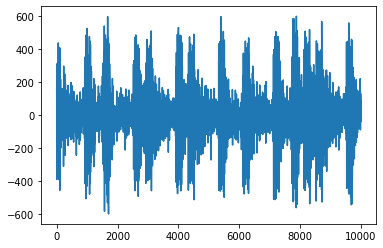

In [254]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('../c.wav')
plt.plot(data[:10000])

In [134]:
def fda(x, floor, ceil, fs):
    print(fs)
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    print(data.shape)
    return data

48000
(168168,)


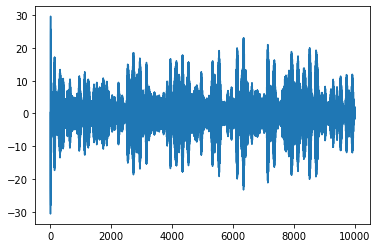

In [255]:
filted = fda(data, 17500, 18500, fs)
plt.plot(filted[:10000])

In [91]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

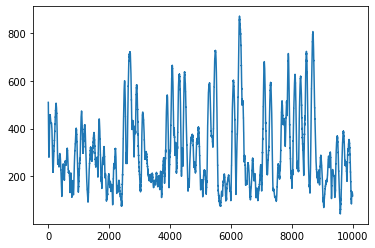

In [256]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[:10000])

In [97]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

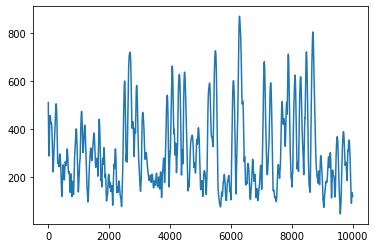

In [257]:
sm_data = smooth(impulse, 5)
plt.plot(sm_data[:10000])

In [260]:
def find_max(data, half_window):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > 0.3 and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [261]:
#impulse_pos = find_max(data, 50)
impulse_pos = find_max(sm_data, 50)
print(impulse_pos)

[60, 255, 1093, 1197, 1673, 2508, 2685, 2903, 3104, 3907, 4072, 4306, 4478, 4932, 5297, 5491, 6082, 6281, 7095, 7305, 7679, 7885, 8107, 8290, 8482, 8694, 10298, 10499, 11091, 11272, 11873, 12089, 12891, 13082, 13291, 13485, 13707, 13877, 14487, 14684, 15096, 15272, 15490, 15693, 15903, 16080, 16299, 16482, 17058, 17300, 17887, 18084, 18678, 18898, 19495, 19679, 20491, 20686, 21095, 21272, 22078, 22288, 22499, 22680, 23474, 23676, 24087, 24268, 24491, 24676, 25315, 25471, 26282, 26484, 27086, 27281, 28095, 28275, 28503, 28684, 29511, 29676, 29903, 30085, 30707, 30884, 31486, 31677, 32483, 32664, 33291, 33475, 33900, 34068, 34307, 34488, 35289, 35468, 36086, 36281, 36397, 36559, 36698, 36876, 37494, 37698, 38490, 38680, 38987, 39078, 39280, 39503, 39688, 40291, 40480, 41287, 41484, 42083, 42281, 42773, 42895, 43084, 43299, 43484, 44296, 44471, 151529, 151642, 151981, 152231, 152291, 152525, 158802, 158977, 159216, 159436, 159568, 159743, 159835, 160075, 160565, 160817, 161046, 161638, 16

In [262]:
def decode(pos):
    N = len(pos)
    d = 50
    eps = 24
    message_2 = [-1] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        print(delta)
        if -eps < delta - d < eps:
            message_2[i * 2 - 1] = 0
            message_2[i * 2] = 0
        elif -eps < delta - d * 2 < eps:
            message_2[i * 2 - 1] = 0
            message_2[i * 2] = 1
        elif -eps < delta - d * 3 < eps:
            message_2[i * 2 - 1] = 1
            message_2[i * 2] = 0
        elif -eps < delta - d * 4 < eps:
            message_2[i * 2 - 1] = 1
            message_2[i * 2] = 1
    message_str = ''.join(map(str, message_2))
    print(message_str)

In [263]:
decode(impulse_pos)

95
738
4
376
735
77
118
101
703
65
134
72
354
265
94
491
99
714
110
274
106
122
83
92
112
1504
101
492
81
501
116
702
91
109
94
122
70
510
97
312
76
118
103
110
77
119
83
476
142
487
97
494
120
497
84
712
95
309
77
706
110
111
81
694
102
311
81
123
85
539
56
711
102
502
95
714
80
128
81
727
65
127
82
522
77
502
91
706
81
527
84
325
68
139
81
701
79
518
95
16
62
39
78
518
104
692
90
207
-9
102
123
85
503
89
707
97
499
98
392
22
89
115
85
712
75
106958
13
239
150
-40
134
6177
75
139
120
32
75
-8
140
390
152
129
492
102
127
2805
186
94
715
93
307
73
147
57
494
1-1-1-1-1-1-1-1-1010101-1-1001000-1-1-1-101-1-101-1-101-1-10101010101-1-101-1-101-1-101-1-10101010100-1-101-1-1-1-1010101010101-1-110-1-101-1-101-1-101-1-101-1-101-1-1010101-1-101-1-1010101-1-100-1-101-1-101-1-1011001-1-1001001-1-101-1-101-1-101-1-101-1-1001001-1-101-1-101-1-1000001-1-101-1-10111-1-1010101-1-101-1-101-1-101-1-1-1-1010101-1-1-1-1-1-1-1-1-1-110-1-110-1-1-1-1100100-1-1-1-110-1-11010-1-10110-1-11101-1-101-1-1001000-1-10

In [153]:
184*3

552

In [158]:
print(data.shape)

(71200,)
